In [1]:
import numpy as np
import math
import pylab
import matplotlib.pyplot as plt
import matplotlib.ticker as tic
import random

In [2]:
#вспомогательные функции для отображения... функций

def make_data(f,bounds = [-2,2], n_pt = 100):
    x = np.arange(bounds[0], bounds[1], (bounds[1] - bounds[0])/n_pt)
    y = np.arange(bounds[0], bounds[1], (bounds[1] - bounds[0])/n_pt)
    xgrid, ygrid = np.meshgrid(x, y) 
    grid = np.stack([xgrid,ygrid],axis = -1)

    z = np.zeros_like(xgrid)
    for i in range(len(ygrid)):
        for j in range(len(grid)):
            z[i][j] = f(grid[i][j])
    
    return xgrid, ygrid, z

def plot_function(f, bounds = [-3,3]):
    _, ax = plt.subplots(subplot_kw=dict(projection='3d'))
    x, y, z = make_data(f,bounds = bounds)
    ax.plot_surface(x, y, z)
    plt.show()

Рассматриваемые функции

In [3]:
#самая простая квадратичная функция
def f_1(point: np.array):
    return np.sum(np.power(point, 2), axis = -1)

#накидал случайных одночленов, а получилас функция, которую не так просто вычислить
def f_2(point):
    x, y = point
    return x*x + 2*x + x*y*y*x -10*x*y

f 1 :


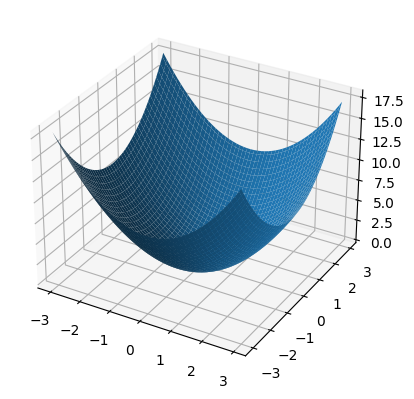

f 2 :


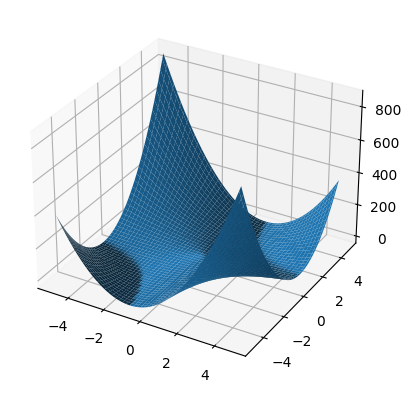

In [70]:
print("f 1 :")
plot_function(f_1)
print("f 2 :")
plot_function(f_2, bounds = [-5,5])

Функции, реализующие поиск градиента и сам градиентный спуск

In [4]:
def grad(func, point, delta = 1e-5):
    delta_x = func(point + (delta, 0)) - func(point)
    delta_y = func(point + (0, delta)) - func(point)
    return np.array([delta_x / delta, delta_y / delta])

In [5]:
def sgd(func, lr = 1e-1, max_steps = 100, start = np.array([[1,1]])):
    points = start

    trace = []
    point = random.choice(points) #выбираем случайную точку из массива точек

    for _ in range(max_steps):
        trace.append(np.mean(points, axis = 0))
        #trace.append(point)

        grd = grad(func, point) #вычисляем градиент
        points = np.array([p - lr*grd for p in points]) #смещаем точки

        if all(np.abs(np.mean(points, axis = 0) - trace[-1]) < 3e-1*lr): #условие окончания по одному наблюдению
            break

        #if len(trace) > 8 and all(np.abs(np.mean(trace[-8:-4], axis = 0) - np.mean(trace[-4:-1], axis = 0) < 1e-3*lr)): #условие окончания по среднему истории
        #    break

        point = random.choice(points) #вфбираем точку для следующего шага

    return np.mean(points, axis = 0), np.array(trace)

Функции для визуализации

In [6]:
def find_extrema(f,bounds = [-2,2], n_pt = 100, delta = 1e-5):
    delta = 1/n_pt
    x = np.arange(bounds[0], bounds[1], (bounds[1] - bounds[0])/n_pt)
    y = np.arange(bounds[0], bounds[1], (bounds[1] - bounds[0])/n_pt)
    xgrid, ygrid = np.meshgrid(x, y) 
    grid = np.stack([xgrid,ygrid],axis = -1)

    extremas = []
    for i in range(len(ygrid)):
        for j in range(len(grid)):
            #print(grad(f, grid[i][j]))
            if all(grad(f, grid[i][j]) > -delta) and all(grad(f, grid[i][j]) < delta):
                extremas.append(grid[i][j])

    return extremas

def depict_descent(f,trace, result, lvlines_freq = 15):
    #функция отображающая траекторию спуска
    print(f"predicted minima point: {result}")
    print(f"descent ended in {len(trace)} steps")
    #отображение позиций ведущих точек
    pylab.plot(np.arange(len(trace)), trace[:,0])
    pylab.plot(np.arange(len(trace)), trace[:,1])
    pylab.show()

    pylab.xlim([-np.max(trace) - 1,np.max(trace) + 1])
    pylab.ylim([-np.max(trace) - 1,np.max(trace) + 1])

    #отображение линий уровня
    x, y, z = make_data(f, bounds = [-np.max(trace) - 1,np.max(trace) + 1])
    plt.contour(x, y, z, levels = np.arange(np.min(z),np.max(z), (np.max(z) - np.min(z)) / lvlines_freq))

    #отображение траектории точки
    pylab.plot(trace[:,0], trace[:,1],color = 'orange')
    pylab.plot(trace[:,0], trace[:,1],"o")
    pylab.plot(trace[0,0], trace[0,1], "o", color = 'red')

    #отображение экстремума
    extremas = find_extrema(f)
    pylab.plot(extremas, "o", color = 'green')

    pylab.show()

Имщем минимумы функций стохастическим градиентным спуском:

подаем на вход группу из 10 случайных точек, и сдвигаем ее в случайном направлении

* хоть для рассчета градиента используется единственная точка, траектории отображаются по среднему значению группы для лучшей читаемости

In [234]:
mean_point_minima, trace = sgd(f_1, start = np.random.rand(10,2) + np.random.rand(2)*20)

predicted minima point: [0.2765365 0.1680732]
descent ended in 15 steps


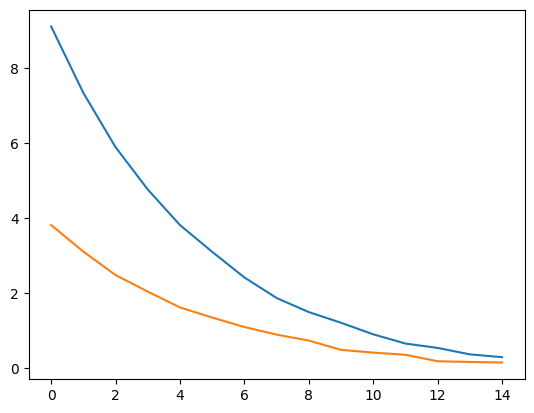

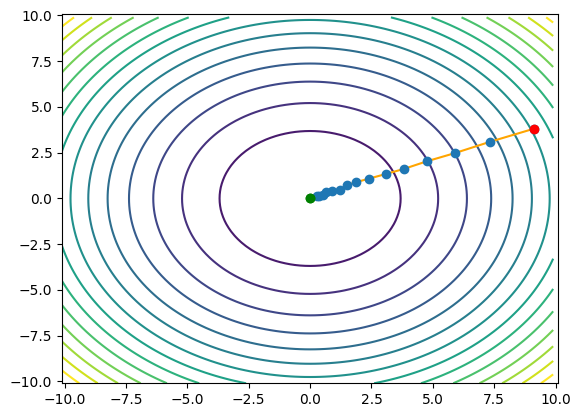

In [235]:
depict_descent(f_1, trace, mean_point_minima)

In [13]:
mean_point_minima, trace = sgd(f_2, lr = 3e-2, max_steps = 500, start = np.random.rand(10,2) + np.random.rand(2)*10)

predicted minima point: [-1.51803638 -3.03247397]
descent ended in 111 steps


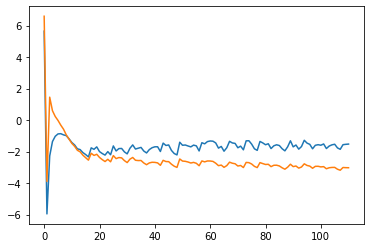

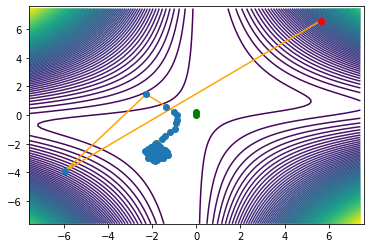

In [14]:
depict_descent(f_2, trace, mean_point_minima, lvlines_freq = 100)

Модификация градиентного спуска

sgd с использованием импульса:

In [15]:
def impulse_sgd(func, lr = 1e-1, alpha = 0.5, max_steps = 100, start = np.array([[1,1]])):
    points = start

    trace = []
    point = random.choice(points) #выбираем случайную точку из массива точек
    impulse = 0

    for i in range(max_steps):
        trace.append(point)

        grd = grad(func, point) #вычисляем градиент

        impulse = alpha*impulse - lr*grd # считаем импульс

        points = np.array([p - lr*grd + alpha*impulse for p in points]) #смещаем точки
        
        if all(np.abs(np.mean(points, axis = 0) - trace[-1]) < 3e-1*lr): #условие окончания
            break

        # if len(trace) > 8 and all(np.abs(np.mean(trace[-8:-4], axis = 0) - np.mean(trace[-4:-1], axis = 0) < 1e-3*lr)): #условие окончания по среднему истории
        #    break

        point = random.choice(points) #вфбираем точку для следующего шага


    return np.mean(points, axis = 0), np.array(trace)

In [267]:
mean_point_minima, trace = impulse_sgd(f_1, start = np.random.rand(10,2) + np.random.rand(2)*20)

predicted minima point: [-0.15595639 -0.09272798]
descent ended in 100 steps


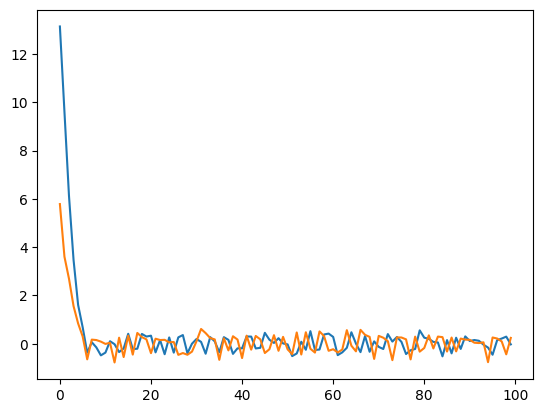

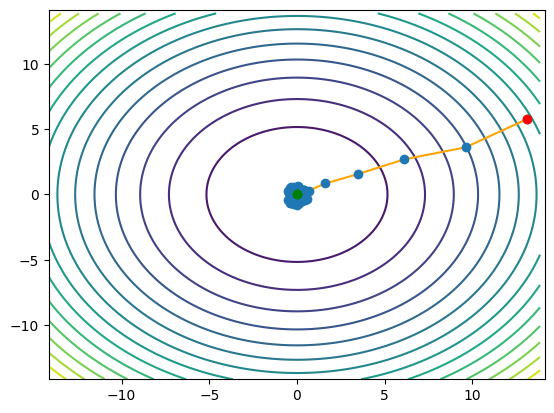

In [268]:
depict_descent(f_1, trace, mean_point_minima)

In [284]:
mean_point_minima, trace = impulse_sgd(f_2, lr = 3e-2, max_steps = 500, 
                                       start = np.random.rand(10,2) + np.random.rand(2)*10)

predicted minima point: [-0.15595639 -0.09272798]
descent ended in 500 steps


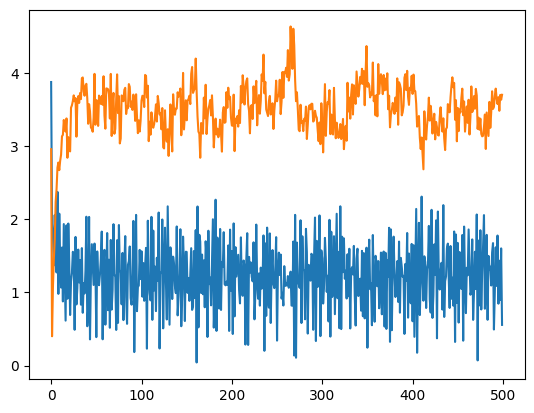

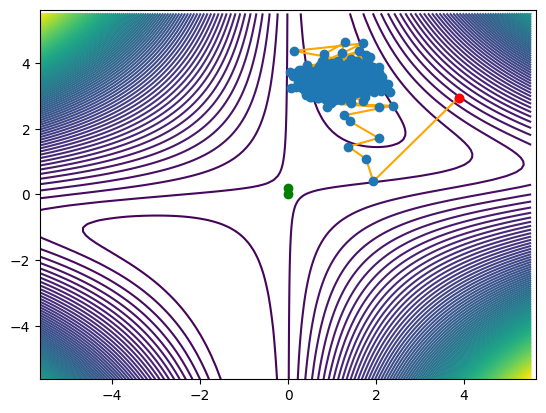

In [285]:
depict_descent(f_2, trace, mean_point_minima, lvlines_freq = 100)

Модификация градиентного спуска, adagrad
* делим градиент на вектор встречаемости признаков, чтобы редко встречающиеся признаки тоже оказывали влияние ра результат

In [319]:
def adagrad(func, lr = 1e-1, alpha = 0.5, max_steps = 100, start = np.array([[1,1]]), eta = 1e-8):
    points = start

    trace = []
    point = random.choice(points) #выбираем случайную точку из массива точек
    update_freq = np.array([0., 0.])

    for i in range(int(max_steps)):
        trace.append(point)

        grd = grad(func, point) #вычисляем градиент

        update_freq += np.power(grd, 2) # обновляем частоты обновлений

        points = np.array([p - lr*grd/np.sqrt((update_freq + eta)) for p in points]) #смещаем точки с учеом частот
                                                                                     #обновлений
        
        point = random.choice(points) #выбираем точку для следующего шага

    return np.mean(points, axis = 0), np.array(trace)

In [320]:
mean_point_minima, trace = adagrad(f_1, max_steps = 1e5, start = np.random.rand(10,2) + np.random.rand(2)*20)

predicted minima point: [0.00502909 0.00536331]
descent ended in 100000 steps


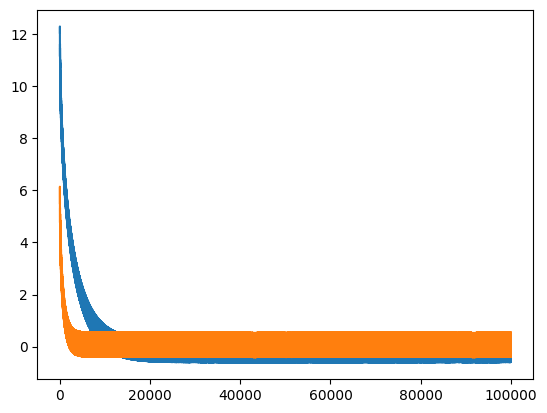

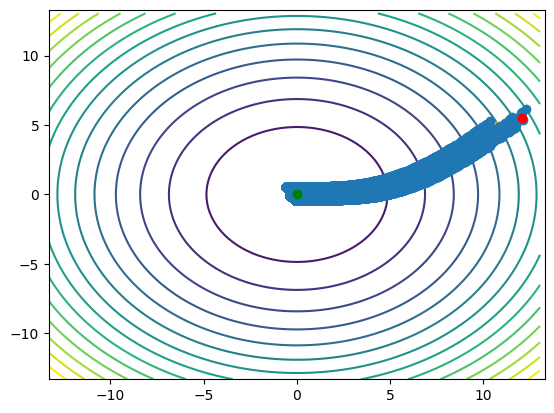

In [321]:
depict_descent(f_1, trace, mean_point_minima)

In [322]:
mean_point_min, trace = adagrad(f_2, lr = 3e-2, max_steps = 1e5, start = np.random.rand(10,2) + np.random.rand(2)*10)

predicted minima point: [0.00502909 0.00536331]
descent ended in 100000 steps


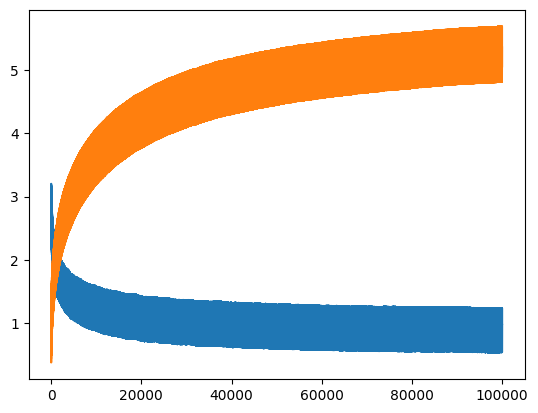

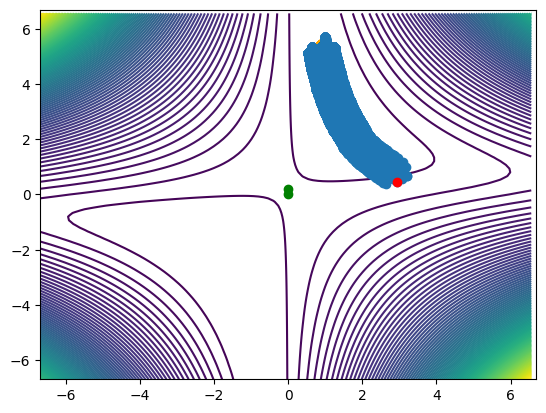

In [323]:
depict_descent(f_2, trace, mean_point_minima, lvlines_freq = 100)